In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib


In [2]:
n_folds = 5
random_state = 108
from datetime import date

today = date.today()
today_stf = '20241008'

In [3]:
try:
    results = pd.read_csv("results/outcome.csv",index_col=0)
except:
    results = pd.DataFrame(columns = ["model",
                                      "test_ci","test_ipcw","test_auc","test_brier","n_features"])

In [4]:
from sksurv.metrics import cumulative_dynamic_auc
def calc_dyn_auc(model,X,y,y_train,time_max=365,time_interval=7):
    
    times = np.arange(1e-5, time_max, time_interval)
    chf_funcs = model.predict_cumulative_hazard_function(X)
    risk_scores = np.row_stack([chf(times) for chf in chf_funcs])
    auc, mean_auc = cumulative_dynamic_auc(y_train, y, risk_scores, times)

    return auc, mean_auc,times

In [5]:
from sksurv.metrics import integrated_brier_score
def calc_ibs(model,X,y,y_train,time_max=365,time_interval=7):
    
    times = np.arange(1e-5, time_max, time_interval)
    surv_prob = np.vstack([fn(times) for fn in model.predict_survival_function(X)])
    ibs = integrated_brier_score(y_train, y, surv_prob, times)

    return ibs

In [6]:
def plot_auc(cph_auc,cph_mean_auc,times):
    plt.plot(times, cph_auc, "o-", label=f"Mean AUC = {cph_mean_auc:0.3f})")
    plt.axhline(cph_mean_auc, linestyle="--",color='r')
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.legend(loc="lower center")
    plt.grid(True)

In [7]:
def plot_cph_coef(cph,feature_names=None):
    coefs = cph.coef_.reshape((-1))
    if feature_names is None:
        feature_names = cph.feature_names_in_
    df = pd.Series(index = feature_names,data=coefs)
    non_zero_coef = df[abs(df) > 0.01].sort_values(ascending=False, key=abs).head(20)
    ax = sns.barplot(x=non_zero_coef.index, y=non_zero_coef.values)
    plt.setp(ax.get_xticklabels(), rotation=45)

In [8]:
def plot_grid_search_results(gcv, ax, name, param = "max_depth"):
    ax.errorbar(
        x=gcv.cv_results_["param_model__estimator__{}".format(param)].filled(),
        y=gcv.cv_results_["mean_test_score"],
        yerr=gcv.cv_results_["std_test_score"],
    )
    ax.plot(
        gcv.best_params_["model__estimator__{}".format(param)],
        gcv.best_score_,
        "ro",
    )
    ax.set_ylabel(name)
    ax.yaxis.grid(True)

In [9]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv)
    
    train_scores_mean = np.nanmean(train_scores, axis=1)
    train_scores_std = np.nanstd(train_scores, axis=1)
    val_scores_mean = np.nanmean(val_scores, axis=1)
    val_scores_std = np.nanstd(val_scores, axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,color='r',alpha=0.2)
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, val_scores_mean-val_scores_std, val_scores_mean+val_scores_std,color='g',alpha=0.2)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Learning Curves")
    plt.show()


In [10]:
def exponential_transformation_gender(row, column,gender_col, bounds, k=1):
    
    if row[gender_col] == 1:
        #male
        lower_bound, upper_bound = bounds["male"][0], bounds["male"][1]
    elif row[gender_col] == 0:
        lower_bound, upper_bound = bounds["female"][0], bounds["female"][1]
    else:
        return np.nan  # Unknown gender handling
    
    value = row[column]
    
    # Apply exponential transformation with scaling factor k
    if lower_bound <= value <= upper_bound:
        return 1  # Optimal range
    elif value < lower_bound:
        return np.exp(k * (lower_bound - value))  # Exponential penalty below range
    else:
        return np.exp(k * (value - upper_bound))  # Exponential penalty above range


In [11]:
def exponential_transformation(row, column, bounds, k=1):
    
    
    lower_bound, upper_bound = bounds[0], bounds[1]
    
    value = row[column]
    
    # Apply exponential transformation with scaling factor k
    if lower_bound <= value <= upper_bound:
        return 1  # Optimal range
    elif value < lower_bound:
        return np.exp(k * (lower_bound - value))  # Exponential penalty below range
    else:
        return np.exp(k * (value - upper_bound))  # Exponential penalty above range


In [12]:
def evaluate_score(model,X_test,y_test,y_train,model_name,time_max=365,time_interval=7):
    try:
        auc, mean_auc,times = calc_dyn_auc(model,X_test,y_test,y_train,time_max,time_interval)
    except:
         mean_auc = None
    try:
        brier = calc_ibs(model,X_test,y_test,y_train,time_max,time_interval)
    except:
        brier = None
    
    prediction = model.predict(X_test)
    c_harrell = concordance_index_censored(y_test["death_in_study"], y_test["event_max"], prediction)
    c_uno = concordance_index_ipcw(y_train, y_test, prediction,tau=time_max)
    
    results = pd.DataFrame(
        data = [[model_name,c_harrell[0],c_uno[0],mean_auc,brier,X_test.shape[1]]],
        columns = ["model", "test_ci","test_ipcw","test_auc","test_brier","n_features"]
    )
    
    return results

In [13]:
# https://www.seslhd.health.nsw.gov.au/sites/default/files/2019-04/NSWHP%20Reference%20Ranges%20Adult%202019.pdf
train = pd.read_csv("train2.csv",index_col = 0)



train['haemoglobin_adj'] = train.apply(exponential_transformation_gender, axis=1, k=2e-2,
                                      column='haemoglobin',gender_col='gender_2.0',
                                     bounds={'male':(130,170),'female':(120,150)})
train['creatinine_adj'] = train.apply(exponential_transformation_gender, axis=1, k=2e-3,
                                      column='creatinine',gender_col='gender_2.0',
                                     bounds={'male':(60,110),'female':(45,90)})
train['albumin_adj'] = train.apply(exponential_transformation, axis=1, k=1e-1,
                                      column='albumin',
                                     bounds=(33,48))
train['platelet_count_adj'] = train.apply(exponential_transformation, axis=1, k=4e-6,
                                      column='platelet_count',
                                     bounds=(150e3,450e3))
#train['inr_adj'] = train.apply(exponential_transformation, axis=1, k=0.5,
#                                      column='inr',
#                                     bounds=(0.8,1.1))

# https://cardiacmri.com/analysis-guide/aortic-valve-2/aortic-stenosis-2/ using mild as upperbound
train['av_peak_vel_adj'] = train.apply(exponential_transformation, axis=1, k=0.5,
                                      column='av_peak_vel',
                                     bounds=(1,3))

# https://cardiacmri.com/analysis-guide/aortic-valve-2/aortic-stenosis-2/ 
train['av_mean_grad_tte_adj'] = train.apply(exponential_transformation, axis=1, k=2e-2,
                                      column='av_mean_grad_tte',
                                     bounds=(0,20))

train['av_area_tte_adj'] = train.apply(exponential_transformation, axis=1, k=1,
                                      column='av_area_tte',
                                     bounds=(2,np.inf))

test = pd.read_csv("test2.csv",index_col = 0)
test['haemoglobin_adj'] = test.apply(exponential_transformation_gender, axis=1, k=2e-2,
                                      column='haemoglobin',gender_col='gender_2.0',
                                     bounds={'male':(130,170),'female':(120,150)})
test['creatinine_adj'] = test.apply(exponential_transformation_gender, axis=1, k=2e-3,
                                      column='creatinine',gender_col='gender_2.0',
                                     bounds={'male':(60,110),'female':(45,90)})
test['albumin_adj'] = test.apply(exponential_transformation, axis=1, k=1e-1,
                                      column='albumin',
                                     bounds=(33,48))
test['platelet_count_adj'] = test.apply(exponential_transformation, axis=1, k=4e-6,
                                      column='platelet_count',
                                     bounds=(150e3,450e3))
#test['inr_adj'] = test.apply(exponential_transformation, axis=1, k=0.5,
#                                      column='inr',
#                                     bounds=(0.8,1.1))
test['av_peak_vel_adj'] = test.apply(exponential_transformation, axis=1, k=0.5,
                                      column='av_peak_vel',
                                     bounds=(1,3))
test['av_mean_grad_tte_adj'] = test.apply(exponential_transformation, axis=1, k=2e-2,
                                      column='av_mean_grad_tte',
                                     bounds=(0,20))

test['av_area_tte_adj'] = test.apply(exponential_transformation, axis=1, k=1,
                                      column='av_area_tte',
                                     bounds=(2,np.inf))

In [14]:
def calc_death_in_year(row,time=415):
    if row["upper_bound"] <= time and row["death_in_study"] == 1:
        return 1
    elif row["upper_bound"] > time and row["upper_bound"]!= row['lower_bound'] and row["death_in_study"] == 1:
        return 2 # this will signal that the follow up came outside the observation time
    else:
        return 0
    

In [15]:
train["time"] = train["event_max"].clip(upper=415)
train['death_one_year'] = train.apply(calc_death_in_year,axis=1)
train = train.query('death_one_year != 2')

test["time"] = test["event_max"].clip(upper=415)
test['death_one_year'] = test.apply(calc_death_in_year,axis=1)
test = test.query('death_one_year != 2')

In [16]:

#X_train = train.query('death_observed == True or death_in_study == False')
outcome_columns = ['death_in_study','upper_bound',
                       'discharge_status_new','fup_status_30d_new', 'fup_status_12mth_new','lower_bound','death_observed',
                  'event_observed', 'event_max','event_min','event_mid',"time","death_one_year"]

X_train = train.drop(outcome_columns,axis=1)
X_train = X_train.drop(["egfr_pre"],axis=1)

In [17]:
categorical_columns_to_keep = [
'gender_2.0', 'cad_1.0', 'prior_acute_mi_1.0', 'prior_cardio_surg_1.0',
       'prior_pci_1.0', 'prior_cabg_1.0', 'prior_valve_replace_1.0',
       'prior_bav_1.0', 'prior_af_1.0', 'prior_generator_1.0', 'prior_ccf_1.0',
       'prior_stroke_1.0', 'prior_tia_1.0', 'prior_carotid_sten_2.0',
       'prior_carotid_sten_3.0', 'prior_carotid_sten_4.0',
       'prior_carotid_sten_5.0', 'prior_pad_1.0', 'chronic_lung_2.0',
       'chronic_lung_3.0', 'chronic_lung_4.0', 'hypertension_1.0',
       'diabetes_1.0', 'ckd_1.0', 'dialysis_1.0', 'meds_ACE_ARB_1.0',
       'meds_aspirin_1.0', 'meds_p2y12_1.0', 'meds_beta_blocker_1.0',
       'meds_doac_1.0', 'meds_statins_1.0', 'meds_diuretics_1.0',
       'nyha_status_3.0', 
    'ecg_rhythm_sinus_1.0',
       'ecg_rhythm_Fibrillation_1.0', 'ecg_rhythm_paced_1.0',
       'ecg_conduct_none_1.0', 'ecg_conduct_RBBB_1.0', 'ecg_conduct_LBBB_1.0',
       'ecg_conduct_1DAVBlock_1.0', 
    'diseased_vessels_number_2.0',
       'diseased_vessels_number_3.0', 'diseased_vessels_number_4.0',
       'prox_lad_1.0', 'aortic_insuff_2.0', 'aortic_insuff_3.0',
       'aortic_insuff_4.0', 'mitral_regurg_1.0', 'av_disease_etiology_2.0',
       'valve_calc_1.0', 'annualar_calc_ctaort_1.0', 'valve_morph_1.0',
       'artery_calc_2.0', 'artery_calc_3.0',
    'artery_calc_4.0',
       'iliofem_tort_2.0', 'iliofem_tort_3.0', 'iliofem_tort_4.0',
       'high_cfa_burif_1.0', 
    #'prev_iliofem_interv_1.0', 
    'procedure_indic_1.0',
       #'valve_in_valve_1.0', 
    'anaesthesia_2.0', 'anaesthesia_4.0',
       'initial_bav_1.0'
    ] 
    #'device_manufacturer_1_2.0',
       #'device_manufacturer_1_3.0',
        #'lvef_value_scale_2.0',
#'lvef_value_scale_3.0',
#'lvef_value_scale_4.0']
cont_columns_to_keep = [
    #'haemoglobin',
    'haemoglobin_adj',
    #'platelet_count',
    'platelet_count_adj',
    #'albumin',
    'albumin_adj',
    'creatinine',
    'creatinine_adj',
    'lvef_value',
    'av_peak_vel',	
    #'av_peak_vel_adj',
    'av_mean_grad_tte',	
    #'av_mean_grad_tte_adj',
    'av_area_tte',	
    #'av_area_tte_adj',
    'weight',
    'age',
    'kccq_summ_bl',
]
#X_train = X_train[categorical_columns_to_keep + cont_columns_to_keep]

In [18]:
logrank_test = pd.read_csv('results/logrank_test.csv',index_col=0)
category_variables = logrank_test.query('reject == True')['category']
vif = pd.read_csv('results/vif_test.csv',index_col=0)

unicoxph = pd.read_csv('results/coxph_univariate_test.csv',index_col=0)
uni_var = unicoxph.query('p < 0.05').index
continuous_variables = vif.query('VIF <= 7.0')['feature']

In [19]:
#column_list = list(category_variables) + list(continuous_variabales)
column_list = uni_var
X_train = X_train[list(categorical_columns_to_keep) + cont_columns_to_keep]

In [20]:

y = train[["time","death_one_year" ]]

records = y.to_records(index=False)
y_train = np.array(records, dtype = records.dtype.descr)


X_test = test.drop(outcome_columns,axis=1)
X_test = X_test.drop(["egfr_pre"],axis=1)
X_test = X_test[list(categorical_columns_to_keep) + cont_columns_to_keep]
#X_test = X_test.loc[:,column_list]
#X_test_scale = scaler.transform(X_test)
#X_test_scale = pd.DataFrame(X_test_scale,columns=X_test.columns,index=test.index)

y_test = test[["time","death_one_year" ]]

records = y_test.to_records(index=False)
y_test = np.array(records, dtype = records.dtype.descr)

In [22]:
from lifelines import CoxPHFitter
#0.25,0.48
# Define a Cox model for censoring (using covariates if available)
lifeline_cph_model = CoxPHFitter()
lifeline_data = pd.concat([X_train,pd.DataFrame(y_train,index=X_train.index)],axis=1)
lifeline_cph_model.fit(lifeline_data, duration_col='time', event_col='death_one_year')

lifeline_cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 7175 total observations, 6537 right-censored observations>
             duration col = 'time'
                event col = 'death_one_year'
      baseline estimation = breslow
   number of observations = 7175
number of events observed = 638
   partial log-likelihood = -5355.03
         time fit was run = 2024-10-12 05:28:47 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
gender_2.0                   0.08      1.08      0.10           -0.12            0.28                0.89                1.32
cad_1.0                     -0.11      0.90      0.10           -0.31            0.09                0.74                1.10
prior_acute_mi_1.0           0.19      1.21      0.12           -0.04            0.42                0.96                1.52
prior_cardio_surg_1.0       -0.28      0.76      0.23           -0.73            0.18                0.48                1.20
prior_pci_1.0                0.01      1.01      0.11           -0.20            0.22                0.82                1.24
prior_cabg_1.0               0.10      1.10      0.24           -0.36            0.56                0.69                1.75
prior_valve_replace_1.0      0.65      1.92      0.31            0.04            1.27                1.04                3.55
prior_bav_1.0                0.02      1.02      0.13           -0.24            0.27                0.79                1.32
prior_af_1.0                 0.30      1.34      0.11            0.09            0.51                1.09                1.66
prior_generator_1.0          0.10      1.11      0.15           -0.20            0.41                0.82                1.50
prior_ccf_1.0                0.16      1.17      0.09           -0.02            0.34                0.98                1.41
prior_stroke_1.0            -0.01      0.99      0.14           -0.29            0.27                0.75                1.31
prior_tia_1.0               -0.09      0.91      0.16           -0.40            0.22                0.67                1.24
prior_carotid_sten_2.0       0.13      1.14      0.27           -0.40            0.66                0.67                1.94
prior_carotid_sten_3.0      -0.01      0.99      0.29           -0.58            0.55                0.56                1.74
prior_carotid_sten_4.0       0.06      1.06      0.17           -0.27            0.38                0.76                1.47
prior_carotid_sten_5.0       0.29      1.33      0.09            0.11            0.46                1.11                1.59
prior_pad_1.0                0.34      1.41      0.10            0.14            0.54                1.15                1.72
chronic_lung_2.0             0.25      1.29      0.10            0.05            0.46                1.05                1.58
chronic_lung_3.0             0.58      1.79      0.12            0.36            0.81                1.43                2.24
chronic_lung_4.0             0.51      1.67      0.18            0.17            0.86                1.19                2.36
hypertension_1.0            -0.10      0.90      0.10           -0.29            0.09                0.75                1.09
diabetes_1.0                 0.01      1.01      0.10           -0.18            0.19                0.84                1.21
ckd_1.0                      0.05      1.05      0.10           -0.15            0.25                0.86                1.28
dialysis_1.0                 0.25      1.29      0.30           -0.33            0.84                0.72                2.31
meds_ACE_ARB_1.0            -0.11      0.90      0.09           -0.27            0.06                0.76                1.06
meds_aspirin_1.0            -0.11      0.89      0.09           -0.29            0.06                0

In [23]:
lifeline_cph_model.baseline_hazard_

,baseline hazard
0.00001,0.003578
1.00000,0.000703
2.00000,0.000502
3.00000,0.000804
4.00000,0.000805
...,...
411.00000,0.000912
412.00000,0.000466
413.00000,0.000000
414.00000,0.000492


In [25]:
from lifelines.fitters.weibull_fitter import WeibullFitter
wbf = WeibullFitter()
wbf.fit(y_train['time'], y_train['death_one_year'])
wbf.print_summary() #6161

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 7175 total observations, 6537 right-censored observations>
   number of observations = 7175
number of events observed = 638
           log-likelihood = -5653.22
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 74881.25  16994.96        41571.74       108190.76
rho_        0.45      0.02            0.42            0.48

         cmp to      z      p  -log2(p)
lambda_    1.00   4.41 <0.005     16.54
rho_       1.00 -31.24 <0.005    709.31
---
AIC = 11310.44

74881.25106354046


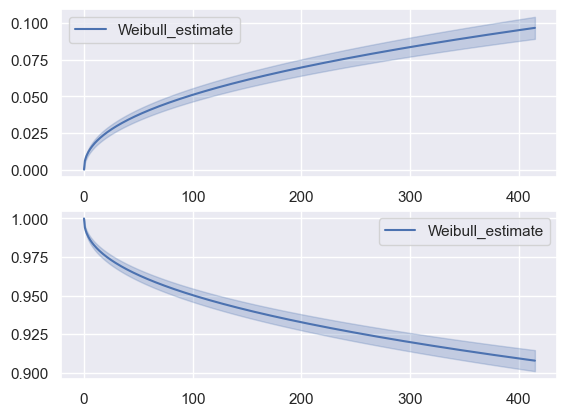

In [26]:
fig,ax = plt.subplots(2,1)
wbf.plot(ax=ax[0])
wbf.plot_survival_function(ax=ax[1])
print(wbf.lambda_)

In [27]:
from lifelines.fitters.exponential_fitter import ExponentialFitter
expfit = ExponentialFitter()
expfit.fit(y_train['time'], y_train['death_one_year'])
expfit.print_summary()

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 7175 total observations, 6537 right-censored observations>
   number of observations = 7175
number of events observed = 638
           log-likelihood = -5931.03
               hypothesis = lambda_ != 0

---
           coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 4008.96    158.72         3697.88         4320.03

         cmp to     z      p  -log2(p)
lambda_    0.00 25.26 <0.005    465.21
---
AIC = 11864.06

4008.9562540089723


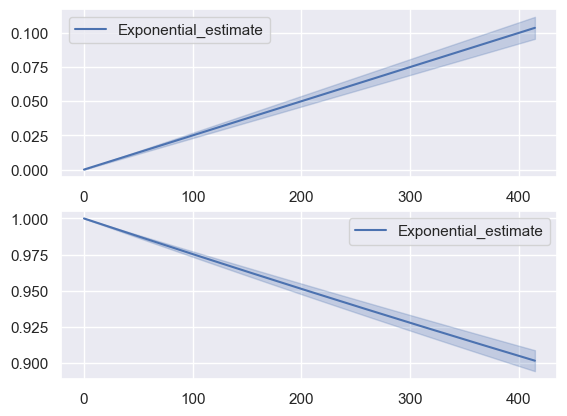

In [28]:
fig,ax = plt.subplots(2,1)
expfit.plot(ax=ax[0])
expfit.plot_survival_function(ax=ax[1])
print(expfit.lambda_)

In [29]:
from lifelines.fitters.log_normal_fitter import LogNormalFitter
lognormfit = LogNormalFitter()
lognormfit.fit(y_train['time'], y_train['death_one_year'])
lognormfit.print_summary()

<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 7175 total observations, 6537 right-censored observations>
   number of observations = 7175
number of events observed = 638
           log-likelihood = -5758.46
               hypothesis = mu_ != 0, sigma_ != 1

---
        coef  se(coef)  coef lower 95%  coef upper 95%
mu_    14.69      0.33           14.04           15.34
sigma_  6.37      0.21            5.97            6.78

        cmp to     z      p  -log2(p)
mu_       0.00 44.17 <0.005       inf
sigma_    1.00 25.90 <0.005    489.04
---
AIC = 11520.91

<Axes: >

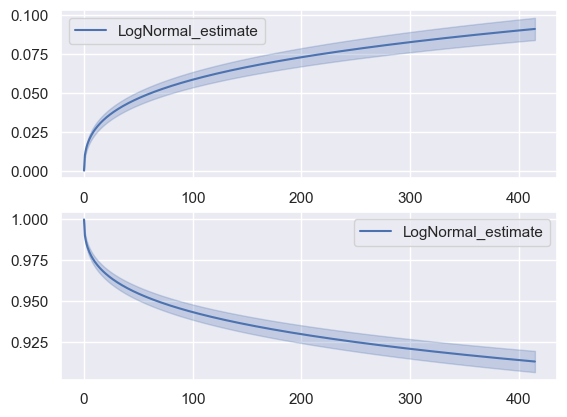

In [30]:
fig,ax = plt.subplots(2,1)
lognormfit.plot(ax=ax[0])
lognormfit.plot_survival_function(ax=ax[1])

In [31]:
from lifelines.fitters.log_logistic_fitter import LogLogisticFitter
loglogfit = LogLogisticFitter()
loglogfit.fit(y_train['time'], y_train['death_one_year'])
loglogfit.print_summary()

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 7175 total observations, 6537 right-censored observations>
   number of observations = 7175
number of events observed = 638
           log-likelihood = -5659.48
               hypothesis = alpha_ != 1, beta_ != 1

---
           coef  se(coef)  coef lower 95%  coef upper 95%
alpha_ 62978.29  13980.51        35577.00        90379.59
beta_      0.46      0.02            0.42            0.49

        cmp to      z      p  -log2(p)
alpha_    1.00   4.50 <0.005     17.20
beta_     1.00 -30.44 <0.005    673.55
---
AIC = 11322.96

<Axes: >

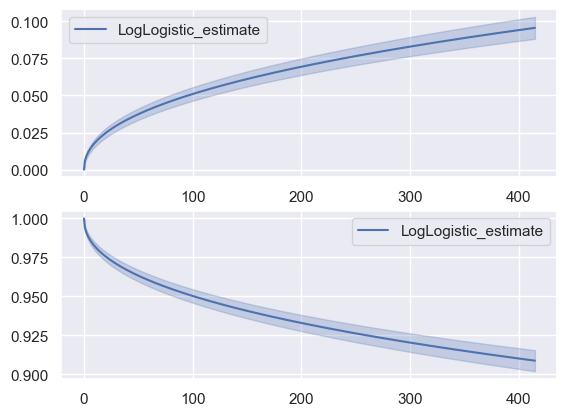

In [32]:
fig,ax = plt.subplots(2,1)
loglogfit.plot(ax=ax[0])
loglogfit.plot_survival_function(ax=ax[1])

In [33]:
# Get the baseline cumulative hazard
baseline_cumulative_hazard = lifeline_cph_model.baseline_cumulative_hazard_

<Axes: >

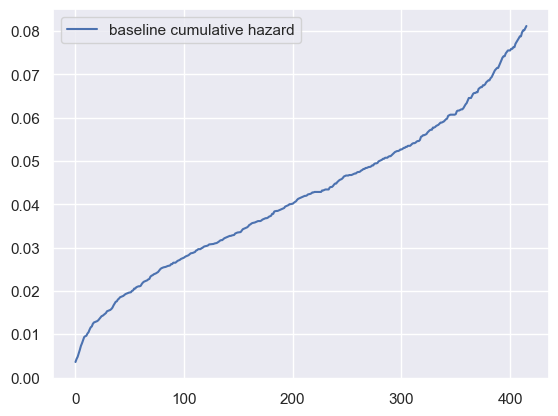

In [34]:
baseline_cumulative_hazard.plot()

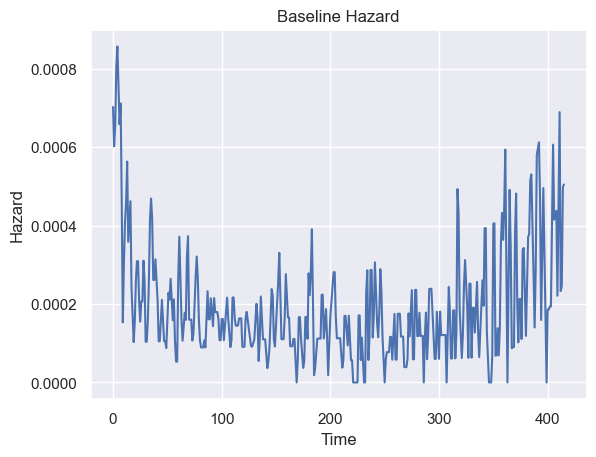

In [35]:

# Extract time points and cumulative hazard values
time_points = baseline_cumulative_hazard.index.values
cum_haz_values = baseline_cumulative_hazard.iloc[:, 0].values

# Numerical differentiation to get the baseline hazard (h_0)
baseline_hazard = np.gradient(cum_haz_values, time_points)

# Plot the baseline hazard
plt.plot(time_points, baseline_hazard)
plt.title("Baseline Hazard")
plt.xlabel("Time")
plt.ylabel("Hazard")
plt.show()


Fitted Exponential Hazard Rate (lambda): 0.00020006787709414553


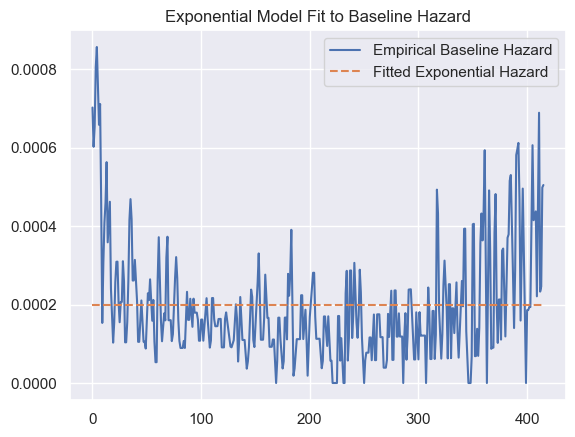

In [36]:
from scipy.optimize import curve_fit

# Define the exponential hazard function h(t) = lambda
def exponential_hazard(t, lam):
    return lam * np.ones_like(t)

# Fit the exponential model to the baseline hazard
popt_exp, _ = curve_fit(exponential_hazard, time_points, baseline_hazard)

# Extract the fitted parameter (lambda)
lambda_exp = popt_exp[0]

print(f"Fitted Exponential Hazard Rate (lambda): {lambda_exp}")

# Plot the fitted exponential hazard
plt.plot(time_points, baseline_hazard, label="Empirical Baseline Hazard")
plt.plot(time_points, exponential_hazard(time_points, lambda_exp), label="Fitted Exponential Hazard", linestyle='--')
plt.legend()
plt.title("Exponential Model Fit to Baseline Hazard")
plt.show()


Fitted Weibull Scale Parameter (lambda): 0.0003463387448942525
Fitted Weibull Shape Parameter (p): 0.9086346771686684


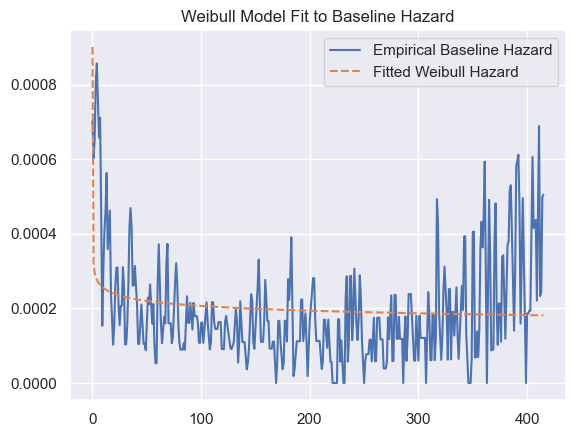

In [37]:
# Define the Weibull hazard function h(t) = lambda * p * t^(p-1)
def weibull_hazard(t, lam, p):
    return lam * p * (t ** (p - 1))

# Fit the Weibull model to the baseline hazard
popt_weibull, _ = curve_fit(weibull_hazard, time_points, baseline_hazard, p0=[1, 1])

# Extract the fitted parameters (lambda, p)
lambda_weibull, p_weibull = popt_weibull

print(f"Fitted Weibull Scale Parameter (lambda): {lambda_weibull}")
print(f"Fitted Weibull Shape Parameter (p): {p_weibull}")

# Plot the fitted Weibull hazard
plt.plot(time_points, baseline_hazard, label="Empirical Baseline Hazard")
plt.plot(time_points, weibull_hazard(time_points, lambda_weibull, p_weibull), label="Fitted Weibull Hazard", linestyle='--')
plt.legend()
plt.title("Weibull Model Fit to Baseline Hazard")
plt.show()


Fitted Log-Normal Location Parameter (mu): 10.792701091261033
Fitted Log-Normal Scale Parameter (sigma): 3.276826091919096


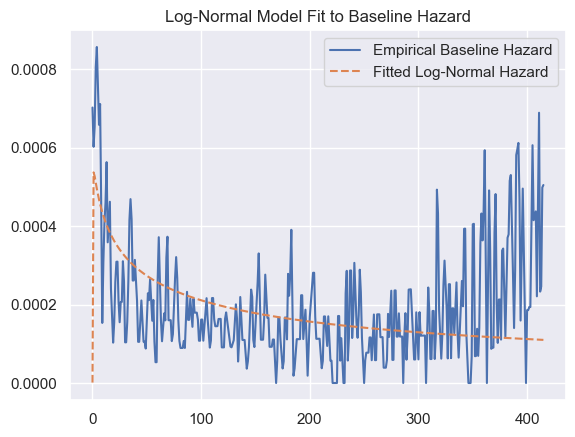

In [38]:
from scipy.stats import lognorm

# Define the log-normal hazard function
def lognormal_hazard(t, mu, sigma):
    pdf = lognorm.pdf(t, sigma, scale=np.exp(mu))
    cdf = lognorm.cdf(t, sigma, scale=np.exp(mu))
    return pdf / (1 - cdf)

# Fit the log-normal model to the baseline hazard
popt_lognormal, _ = curve_fit(lognormal_hazard, time_points, baseline_hazard, p0=[1, 1])

# Extract the fitted parameters (mu and sigma)
mu_lognormal, sigma_lognormal = popt_lognormal

print(f"Fitted Log-Normal Location Parameter (mu): {mu_lognormal}")
print(f"Fitted Log-Normal Scale Parameter (sigma): {sigma_lognormal}")

# Plot the fitted Log-Normal hazard
plt.plot(time_points, baseline_hazard, label="Empirical Baseline Hazard")
plt.plot(time_points, lognormal_hazard(time_points, mu_lognormal, sigma_lognormal), label="Fitted Log-Normal Hazard", linestyle='--')
plt.legend()
plt.title("Log-Normal Model Fit to Baseline Hazard")
plt.show()



Fitted Log-Logistic Scale Parameter (lambda): 0.00035876773639940344
Fitted Log-Logistic Shape Parameter (p): 0.9153827543836756


C:\Users\harri\AppData\Local\Temp\ipykernel_22732\3669801029.py:6: RuntimeWarning: invalid value encountered in power
  return (lam * p * (t ** (p - 1))) / (1 + (lam * t) ** p)


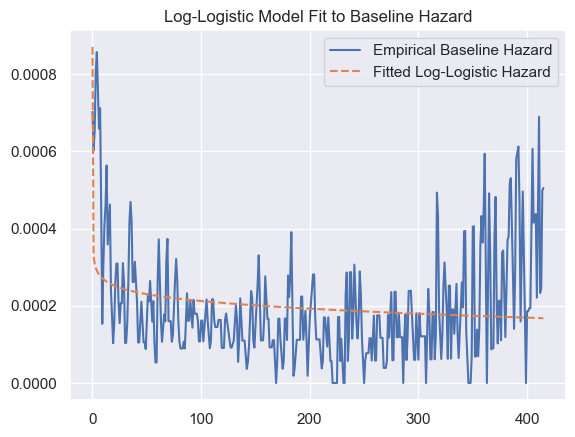

In [39]:
from scipy.optimize import curve_fit
import numpy as np

# Define the log-logistic hazard function
def loglogistic_hazard(t, lam, p):
    return (lam * p * (t ** (p - 1))) / (1 + (lam * t) ** p)

# Fit the log-logistic model to the baseline hazard
popt_loglogistic, _ = curve_fit(loglogistic_hazard, time_points, baseline_hazard, p0=[1, 1])

# Extract the fitted parameters (lambda and p)
lambda_loglogistic, p_loglogistic = popt_loglogistic

print(f"Fitted Log-Logistic Scale Parameter (lambda): {lambda_loglogistic}")
print(f"Fitted Log-Logistic Shape Parameter (p): {p_loglogistic}")

# Plot the fitted Log-Logistic hazard
import matplotlib.pyplot as plt
plt.plot(time_points, baseline_hazard, label="Empirical Baseline Hazard")
plt.plot(time_points, loglogistic_hazard(time_points, lambda_loglogistic, p_loglogistic), label="Fitted Log-Logistic Hazard", linestyle='--')
plt.legend()
plt.title("Log-Logistic Model Fit to Baseline Hazard")
plt.show()


In [40]:
# Calculate residuals for each model
residuals_exp = np.sum((baseline_hazard - exponential_hazard(time_points, lambda_exp)) ** 2)
residuals_weibull = np.sum((baseline_hazard - weibull_hazard(time_points, lambda_weibull, p_weibull)) ** 2)
# Calculate residuals for Log-Logistic and Log-Normal models
residuals_loglogistic = np.sum((baseline_hazard - loglogistic_hazard(time_points, lambda_loglogistic, p_loglogistic)) ** 2)
residuals_lognormal = np.sum((baseline_hazard - lognormal_hazard(time_points, mu_lognormal, sigma_lognormal)) ** 2)

print(f"Sum of Squared Residuals (Log-Logistic): {residuals_loglogistic}")
print(f"Sum of Squared Residuals (Log-Normal): {residuals_lognormal}")



print(f"Sum of Squared Residuals (Exponential): {residuals_exp}")
print(f"Sum of Squared Residuals (Weibull): {residuals_weibull}")


Sum of Squared Residuals (Log-Logistic): 7.691387092986782e-06
Sum of Squared Residuals (Log-Normal): 8.35962371620936e-06
Sum of Squared Residuals (Exponential): 8.404440069547226e-06
Sum of Squared Residuals (Weibull): 7.6145461635033e-06


In [41]:
def compute_aic(residuals,dof,n):
    return 2 * dof + n * np.log(residuals / n)

In [42]:
import numpy as np

n = len(time_points)  # Number of data points

# Calculate AIC for Exponential (1 parameter)
aic_exp = compute_aic(residuals_exp,1,n)

# Calculate AIC for Weibull (2 parameters)
aic_weibull = compute_aic(residuals_weibull,2, n)

aic_loglogistic = compute_aic(residuals_loglogistic,2,n)

# Calculate AIC for Weibull (2 parameters)
aic_lognormal = compute_aic(residuals_lognormal,2, n)

print(f"AIC (Exponential): {aic_exp}")
print(f"AIC (Weibull): {aic_weibull}")

print(f"AIC (Loglogistic): {aic_loglogistic}")
print(f"AIC (Lognormal): {aic_lognormal}")



AIC (Exponential): -6714.858468916627
AIC (Weibull): -6750.463077110328
AIC (Loglogistic): -6746.637548852121
AIC (Lognormal): -6714.895572988487


In [43]:
# Calculate BIC for Exponential (1 parameter)
bic_exp = np.log(n) * 1 + n * np.log(residuals_exp / n)

# Calculate BIC for Weibull (2 parameters)
bic_weibull = np.log(n) * 2 + n * np.log(residuals_weibull / n)

print(f"BIC (Exponential): {bic_exp}")
print(f"BIC (Weibull): {bic_weibull}")


BIC (Exponential): -6710.9156695415
BIC (Weibull): -6742.577478360075
